In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/usr0/home/naveenr/projects/patient_provider')

In [71]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import argparse
import secrets
import json
import matplotlib as mpl
from copy import deepcopy
import scipy.stats as stats 
import geopandas as gpd
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors


In [5]:
from patient.utils import get_results_matching_parameters,aggregate_data, aggregate_normalize_data
from patient.plotting import *

In [6]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')

In [7]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [8]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.rcParams['savefig.bbox'] = 'tight'

In [9]:
colors_by_method = {}
baseline_methods = ['random','greedy_basic','greedy','']
lp_methods = ['lp','lp_multiple_match','lp_fairness','lp_more_patients','lp_threshold']
patient_provider_methods = ['group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference','gradient_descent_2']
linear_regularization_methods = ['provider_focused_linear_regularization_{}'.format(i) for i in [0.25,0.5,1,2,4]]
log_regularization_methods = ['provider_focused_log_regularization_{}'.format(i) for i in [0.25,0.5,1,2,4]]

greys = plt.cm.Greys(np.linspace(0, 1, len(baseline_methods)+1))
vidris = plt.cm.coolwarm(np.linspace(0, 1, len(lp_methods)))
wistia = plt.cm.Wistia(np.linspace(0, 1, len(patient_provider_methods)))
vidris_2 = plt.cm.coolwarm(np.linspace(0, 1, len(linear_regularization_methods)))
wistia_2 = plt.cm.Wistia(np.linspace(0, 1, len(log_regularization_methods)))


for i,m in enumerate(baseline_methods):
    colors_by_method[m] = greys[i+1]
for i,m in enumerate(lp_methods):
    colors_by_method[m] = vidris[i]
for i,m in enumerate(patient_provider_methods):
    colors_by_method[m] = wistia[i]
for i,m in enumerate(linear_regularization_methods):
    colors_by_method[m] = vidris_2[i]
for i,m in enumerate(log_regularization_methods):
    colors_by_method[m] = wistia_2[i]


colors_by_method['optimal'] = np.array([0.9,0.05,0.05,1.0])
colors_by_method['optimal_order'] = np.array([0.9,0.05,0.05,1.0])

In [10]:
shapes_by_method = {}
all_shapes = ['P','o','v','D','s','x','^','<','>']
for i,m in enumerate(baseline_methods+lp_methods+patient_provider_methods):
    shapes_by_method[m] = all_shapes[i%len(all_shapes)]

In [11]:
style_size = 'paper'

In [12]:
methods = ['random','greedy','lp','group_based','gradient_descent_fast']
method_labels = ["Random","Greedy","Linear Programming","Group-Based","Gradient Descent"]

# EC Plots

## Performance Comparison

In [59]:
x_values = [2,3,4,5]
dataset = 'small'

provider_y_values = [[] for i in range(len(methods))]
provider_y_confidences = [[] for i in range(len(methods))]
baseline_params = {'num_patients': 2}
for i in range(len(x_values)):
    baseline_params['num_providers'] = x_values[i] 

    results = get_results_matching_parameters(dataset,"",baseline_params)
    aggregate_data = aggregate_normalize_data(results,baseline="optimal")
    for method in range(len(labels)):
        provider_y_values[method].append(aggregate_data['{}_utilities'.format(methods[method])][0])
        provider_y_confidences[method].append(aggregate_data['{}_utilities'.format(methods[method])][1]/len(results)**.5)

In [60]:
patient_y_values = [[] for i in range(len(methods))]
patient_y_confidences = [[] for i in range(len(methods))]
baseline_params = {'num_providers': 2}
for i in range(len(x_values)):
    baseline_params['num_patients'] = x_values[i] 

    results = get_results_matching_parameters(dataset,"",baseline_params)
    aggregate_data = aggregate_normalize_data(results,baseline="optimal")
    for method in range(len(labels)):
        patient_y_values[method].append(aggregate_data['{}_utilities'.format(methods[method])][0])
        patient_y_confidences[method].append(aggregate_data['{}_utilities'.format(methods[method])][1]/len(results)**.5)

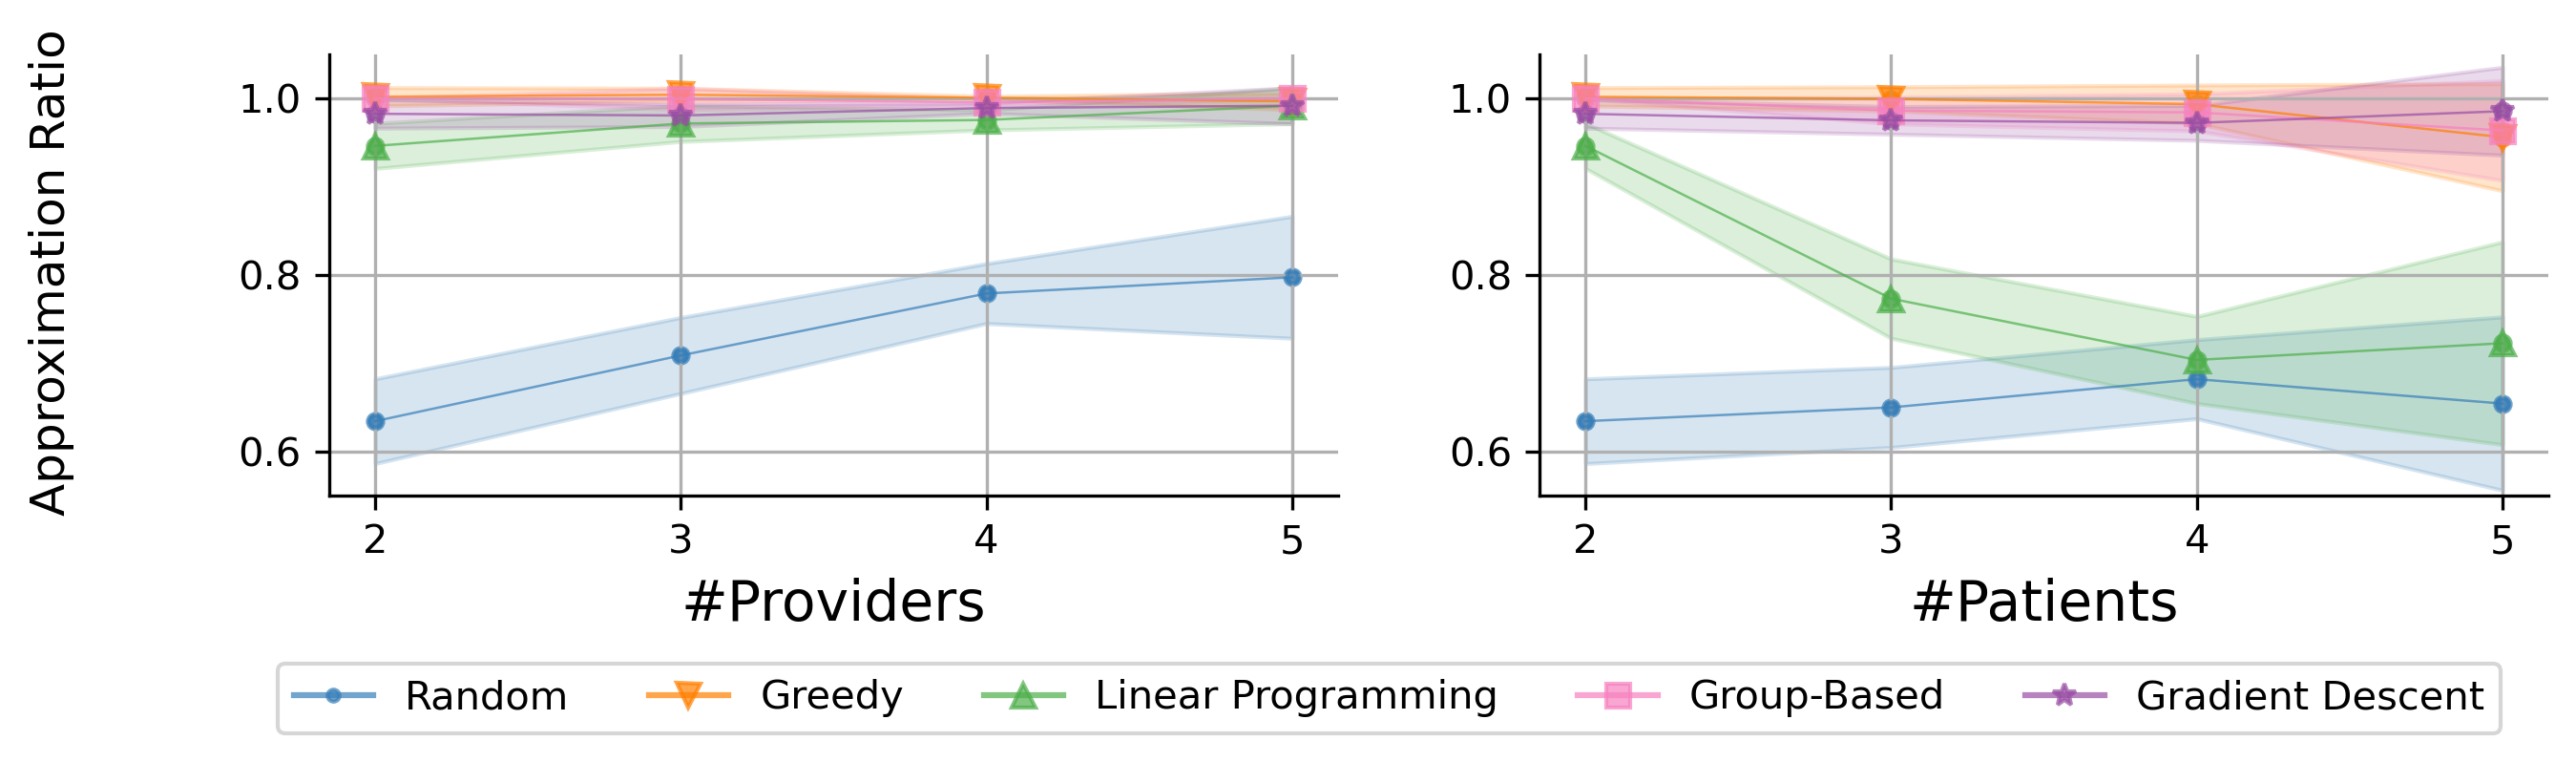

In [122]:
plot_dimensions = (1,2)
x_labels = [["#Providers","#Patients"]]
sup_y_label = "Approximation Ratio"
overall_format = {'figsize':(10,2),
    'style_size': style_size,
    'x_ticks': [[[[2,3,4,5],[2,3,4,5]],[[2,3,4,5],[2,3,4,5]]]],
    'y_ticks': [[[[0.6,0.8,1.0],[0.6,0.8,1.0]],[[0.6,0.8,1.0],[0.6,0.8,1.0]]]],
    'y_lim': [[[0.55,1.05],[0.55,1.05]]],
    'has_grid': True, 
}

fig,ax = create_axes(plot_dimensions,overall_format,x_labels=x_labels,sup_y_label=sup_y_label)

line_format = {'color_palette': 'six_color', 'size': 15}
plot_line(ax[0][0],[x_values for i in range(len(provider_y_values))],provider_y_values,provider_y_confidences,method_labels,line_format)
plot_scatter(ax[0][0],[x_values for i in range(len(provider_y_values))],provider_y_values,line_format)

plot_line(ax[0][1],[x_values for i in range(len(patient_y_values))],patient_y_values,patient_y_confidences,method_labels,line_format)
plot_scatter(ax[0][1],[x_values for i in range(len(patient_y_confidences))],patient_y_values,line_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'lower left', 'ncol': 5, 'bbox_to_anchor': (0.1,-0.34), 'show_point': True}
create_legend(fig,ax,plot_dimensions,legend_format)

fig.savefig("../../results/figures/small_patient_provider.pdf",dpi=300, bbox_inches='tight')

In [113]:
top_choice_probs = [0.1,0.25,0.5,0.75,0.9]
utility_functions = ['uniform','normal']
dataset = "policy_comparison"

y_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]

baseline_params = {'num_patients': 5, 'num_providers': 5, 'max_menu_size': 50}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['utility_function'] = utility_functions[i]
        baseline_params['top_choice_prob'] = top_choice_probs[j]
        

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")

        y_value_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
        y_confidence_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][1]/((100*len(results))**.5) for method in methods]

In [131]:
top_choice_probs = [0.1,0.25,0.5,0.75,0.9]
utility_functions = ['uniform','normal']

x_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]

baseline_params = {'num_patients': 5, 'num_providers': 5, 'max_menu_size': 50}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['utility_function'] = utility_functions[i]
        baseline_params['top_choice_prob'] = top_choice_probs[j]
        

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")

        x_value_matrix[i][j] = [aggregate_data['{}_minimums'.format(method)][0] for method in methods]

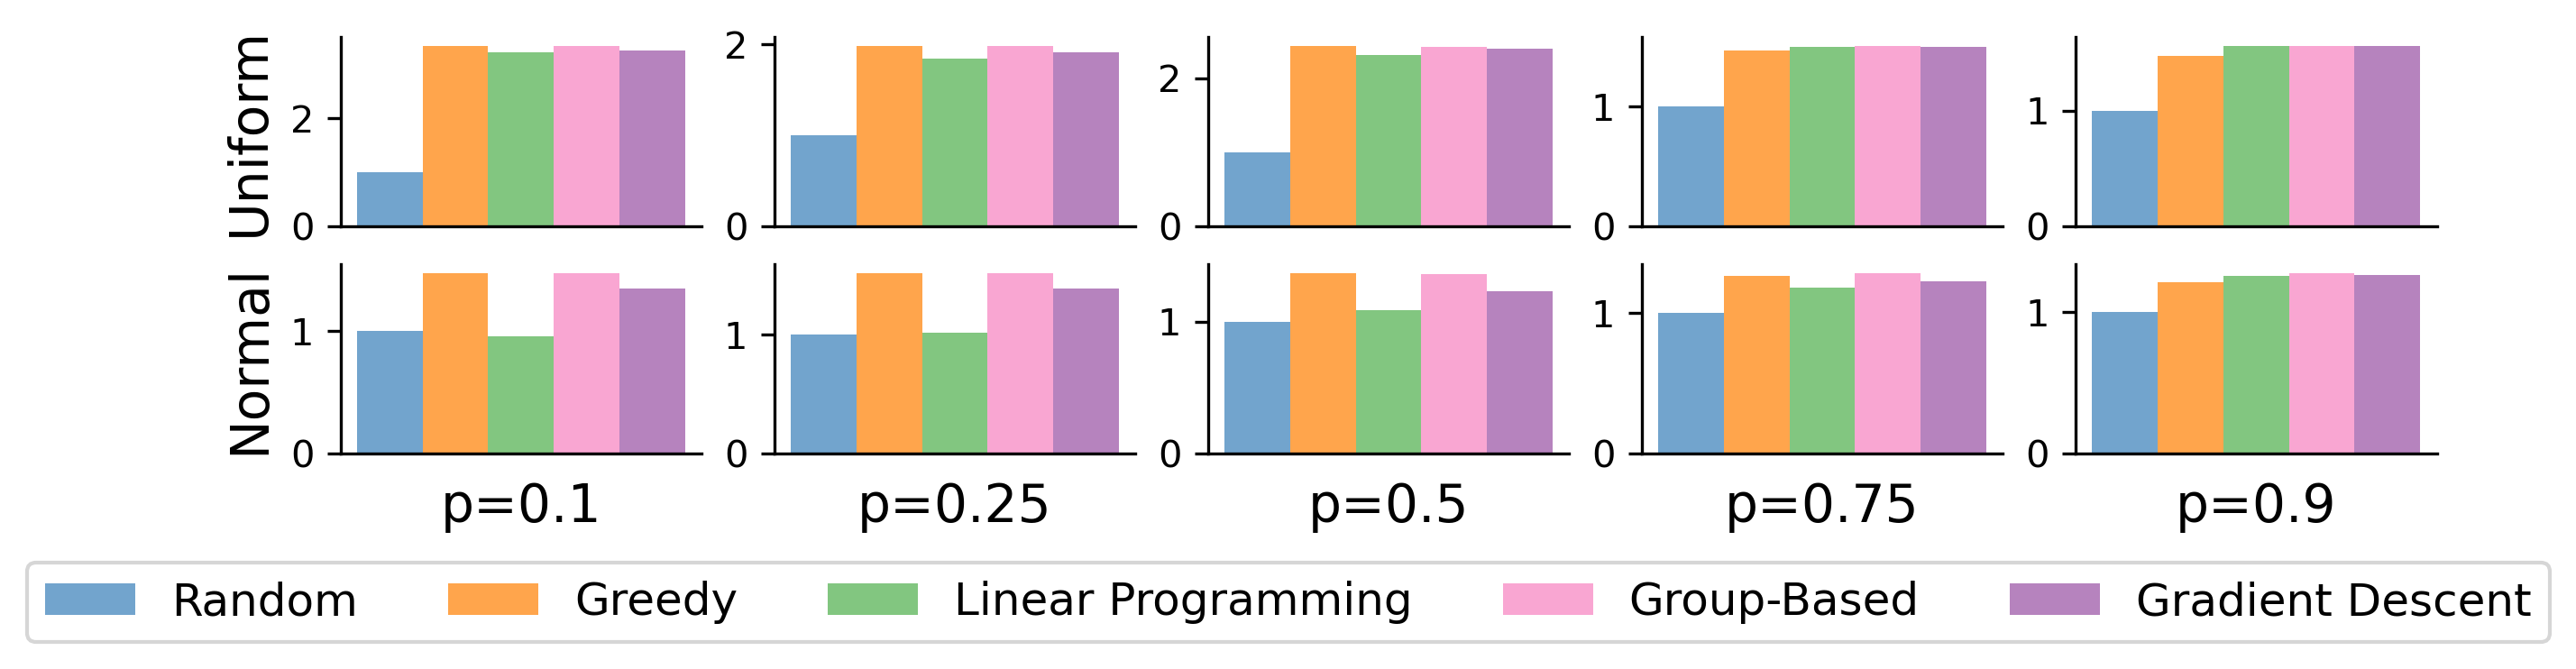

In [150]:
plot_dimensions = (2,5)
x_labels = [["","","","",""],["p=0.1","p=0.25","p=0.5","p=0.75","p=0.9"]]
y_labels = [["Uniform","","","",""],["Normal","","","",""]]
sup_y_label = "Normalized Reward"

overall_format = {'figsize':(10, 2),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(5)] for i in range(2)]
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels)

bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

for i in range(2):
    for j in range(5):
        x_groups = [0,1,2,3,4]
        y_values = y_value_matrix[i][j]
        y_errors = y_confidence_matrix[i][j]
        labels = method_labels
        plot_bar(ax[i][j],x_groups,y_values,y_errors,labels,bar_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 5, 'bbox_to_anchor': (0.95,-0.05)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/policy_comparison.pdf",dpi=300, bbox_inches='tight')

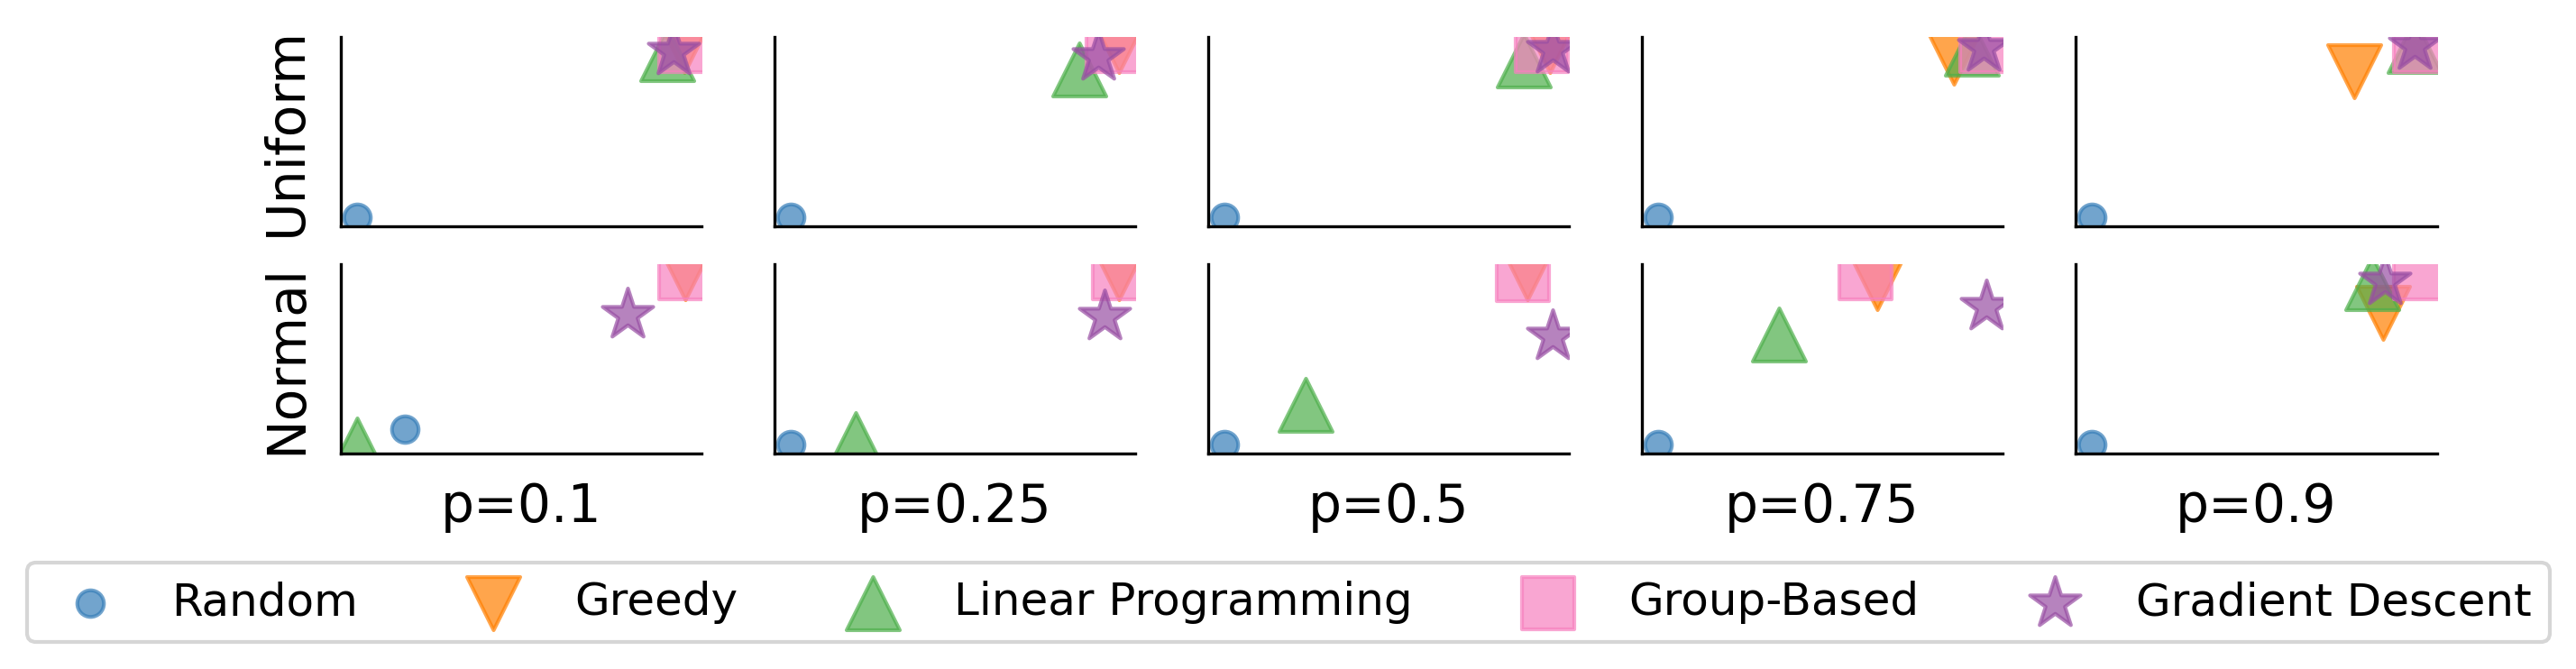

In [159]:
plot_dimensions = (2,5)
x_labels = [["","","","",""],["p=0.1","p=0.25","p=0.5","p=0.75","p=0.9"]]
y_labels = [["Uniform","","","",""],["Normal","","","",""]]
sup_y_label = "Normalized Reward"

figsize = (10,4.75)

overall_format = {'figsize':(10, 2),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(5)] for i in range(2)],
    'y_ticks': [[[[],[]] for i in range(5)] for i in range(2)],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels)

scatter_format = {'color_palette': 'six_color', 'size': 200}

for i in range(2):
    for j in range(5):
        x_values = [[k] for k in x_value_matrix[i][j]]
        y_values = y_value_matrix[i][j]
        y_values = [[k] for k in y_values]
        labels = method_labels
        plot_scatter(ax[i][j],x_values,y_values,labels,scatter_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 5, 'bbox_to_anchor': (0.95,-0.05)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/fairness_comparison.pdf",dpi=300, bbox_inches='tight')

In [178]:
ratio_y_values = [[] for i in range(len(methods))]
ratio_confidences = [[] for i in range(len(methods))]
baseline_params = {'num_providers': 5,'max_menu_size': 500}
dataset = "providers_patients"
x_values = [1,2,4,6,8]
for i in range(len(x_values)):
    baseline_params['num_patients'] = x_values[i]*5

    results = get_results_matching_parameters(dataset,"",baseline_params)
    aggregate_data = aggregate_normalize_data(results,baseline="random")
    for method in range(len(labels)):
        ratio_y_values[method].append(aggregate_data['{}_utilities'.format(methods[method])][0])
        ratio_confidences[method].append(aggregate_data['{}_utilities'.format(methods[method])][1]/len(results)**.5)

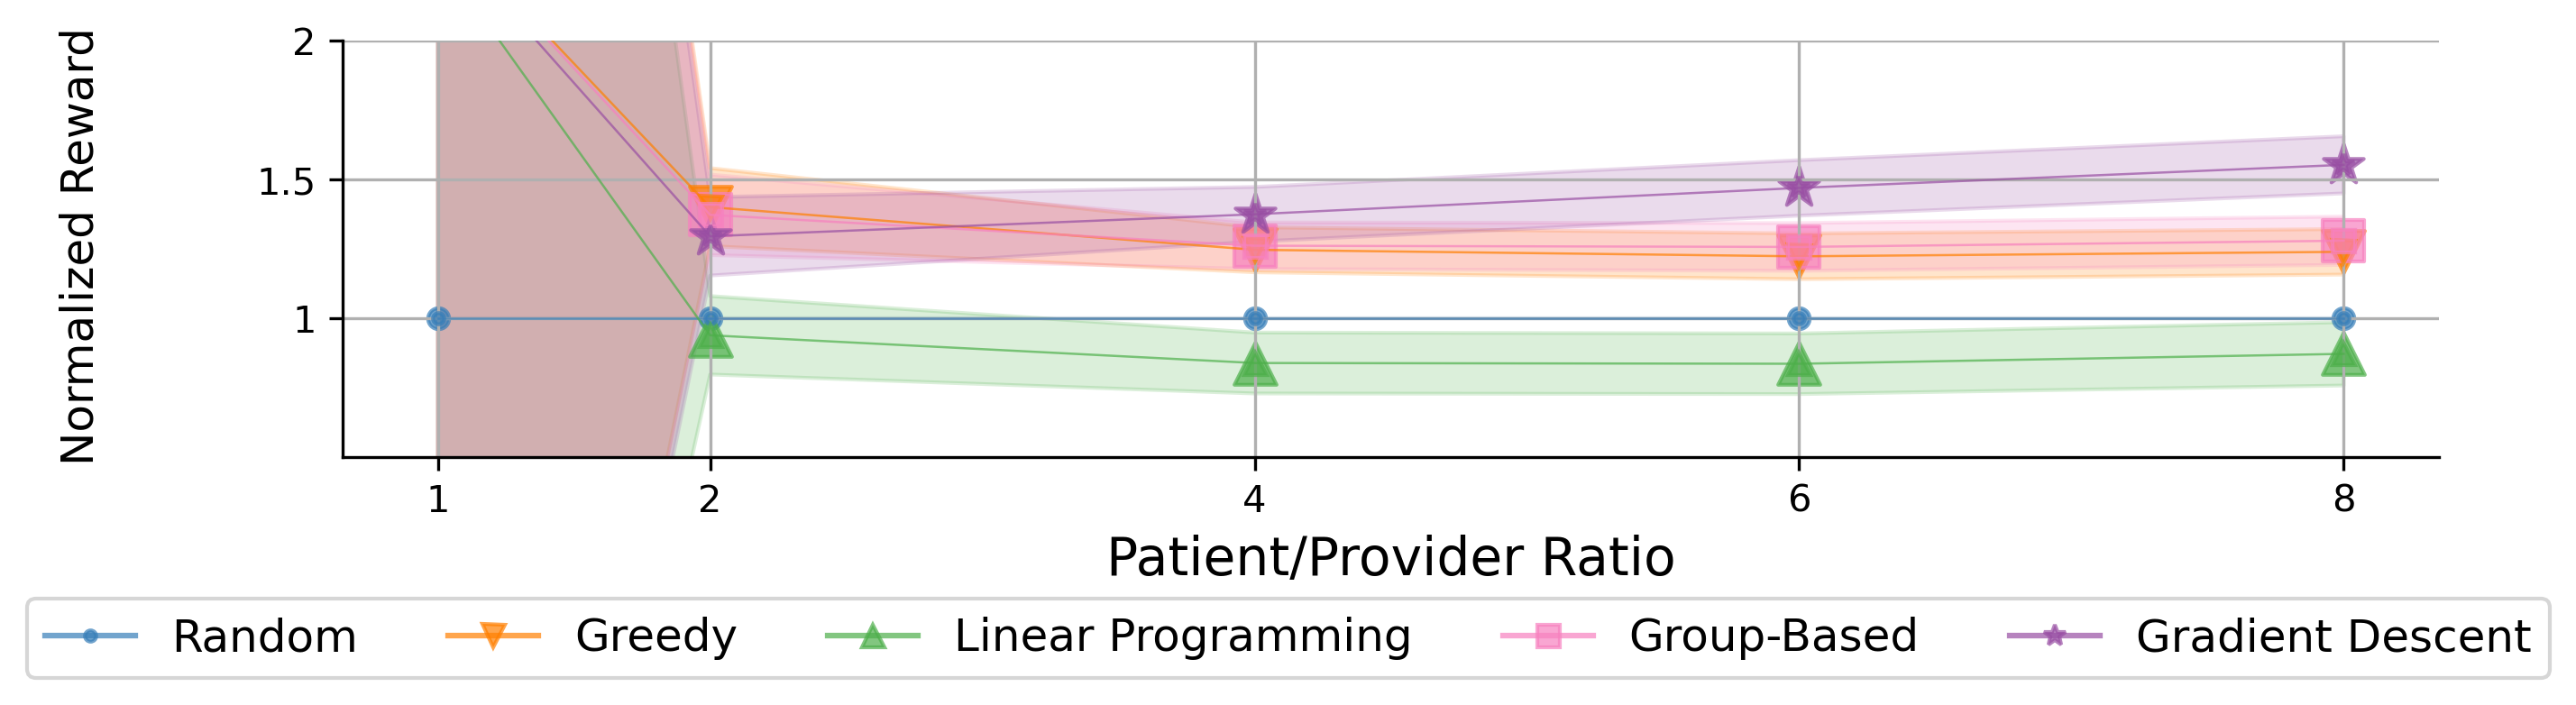

In [193]:
plot_dimensions = (1,1)
x_labels = [["Patient/Provider Ratio"]]
y_labels = [["Normalized Reward"]]
overall_format = {'figsize':(10,2),
    'style_size': style_size,
    'x_ticks': [[[x_values,x_values]]],
    'y_ticks': [[[[1,1.5,2],[1,1.5,2]]]],
    'y_lim': [[[0.5,1.75]]],
    'has_grid': True, 
}

fig,ax = create_axes(plot_dimensions,overall_format,x_labels=x_labels,sup_y_label=sup_y_label)

line_format = {'color_palette': 'six_color', 'size': 125}
plot_line(ax[0][0],[x_values for i in range(len(ratio_y_values))],ratio_y_values,ratio_confidences,method_labels,line_format)
plot_scatter(ax[0][0],[x_values for i in range(len(ratio_y_values))],ratio_y_values,[None for i in range(len(method_labels))],line_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'lower left', 'ncol': 5, 'bbox_to_anchor': (0,-0.34), 'show_point': True}
create_legend(fig,ax,plot_dimensions,legend_format)

fig.savefig("../../results/figures/vary_providers_patients.pdf",dpi=300, bbox_inches='tight')

In [201]:
exit_options = [0.1,0.25,0.5,0.75]
choice_models = ['mnl','threshold']
dataset = "misspecification"

y_value_matrix = [[[0 for i in range(5)] for i in range(4)] for i in range(2)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(4)] for i in range(2)]

baseline_params = {'num_patients': 5, 'num_providers': 5,'top_choice_prob': 0.5}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['choice_model'] = choice_models[i]
        baseline_params['exit_option'] = exit_options[j]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")

        y_value_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
        y_confidence_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][1]/((100*len(results))**.5) for method in methods]

15
15
15
15
15
15
15
15


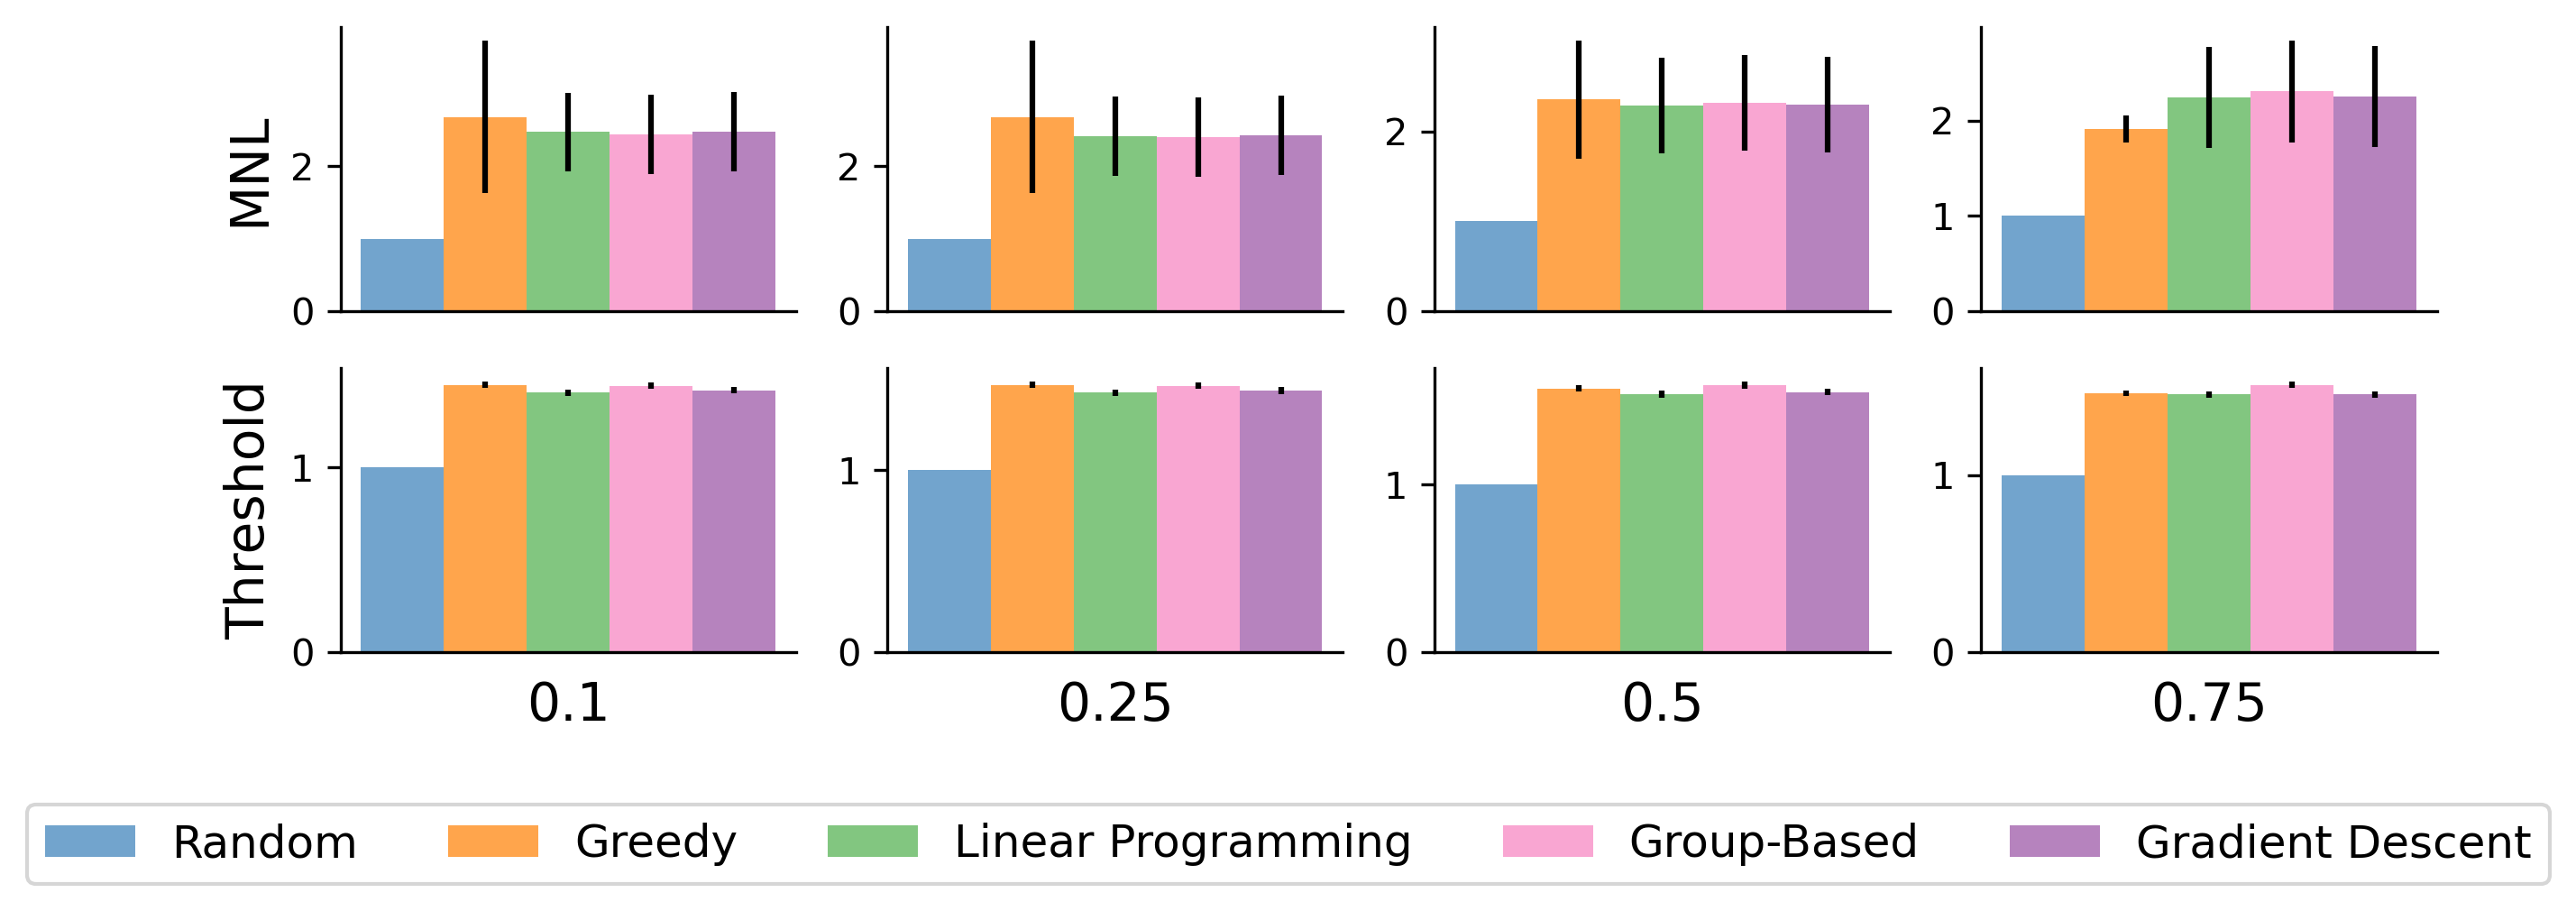

In [205]:
plot_dimensions = (2,4)
x_labels = [["","","",""],["0.1","0.25","0.5","0.75","0.9"]]
y_labels = [["MNL","","",""],["Threshold","","","",""]]
sup_y_label = "Normalized Reward"

overall_format = {'figsize':(10, 3),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(5)] for i in range(2)]
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels)

bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

for i in range(2):
    for j in range(4):
        x_groups = [0,1,2,3,4]
        y_values = y_value_matrix[i][j]
        y_errors = y_confidence_matrix[i][j]
        labels = method_labels
        plot_bar(ax[i][j],x_groups,y_values,y_errors,labels,bar_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 5, 'bbox_to_anchor': (0.95,-0.05)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/other_choice_models.pdf",dpi=300, bbox_inches='tight')

In [126]:
dataset="semi_synthetic"
baseline_params = {'utility_function': 'semi_synthetic', 'num_patients': 205, 'batch_size': 1, 'max_menu_size': 1000}
matches_by_zipcode = {}
match_quality_by_zipcode = {}
for seed in range(43,58):
    baseline_params['seed'] = seed
    results = get_results_matching_parameters(dataset,"",baseline_params)

    match_rates_per = np.array(results[0]['gradient_descent_fast_matches_per'])
    match_times = np.sum(match_rates_per[0],axis=1)
    patient_data = json.load(open("../../data/patient_data_{}_205_140.json".format(seed)))
    theta_data = json.load(open("../../data/patient_data_{}_205_140.json".format(seed)))

    for i in range(len(match_times)):
        zip_val = patient_data[i]['location']
        if zip_val not in matches_by_zipcode:
            matches_by_zipcode[zip_val] = []
        matches_by_zipcode[zip_val].append(match_times[i])

    theta_data = np.array(json.load(open("../../data/{}_205_140.json".format(seed)))[0])
    avg_match_quality = np.sum(theta_data*match_rates_per[0],axis=1)
    avg_match_quality[match_times>0] /= match_times[match_times>0]

    for i in range(len(avg_match_quality)):
        zip_val = patient_data[i]['location']
        if zip_val not in match_quality_by_zipcode:
            match_quality_by_zipcode[zip_val] = []
        if avg_match_quality[i] > 0:
            match_quality_by_zipcode[zip_val].append(10.1/avg_match_quality[i])

for i in matches_by_zipcode:
    matches_by_zipcode[i] = np.mean(matches_by_zipcode[i])
    match_quality_by_zipcode[i] = np.mean(match_quality_by_zipcode[i])

/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("coolwarm").copy()
  
/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("coolwarm").copy()
  from ipykernel import kernelapp as app


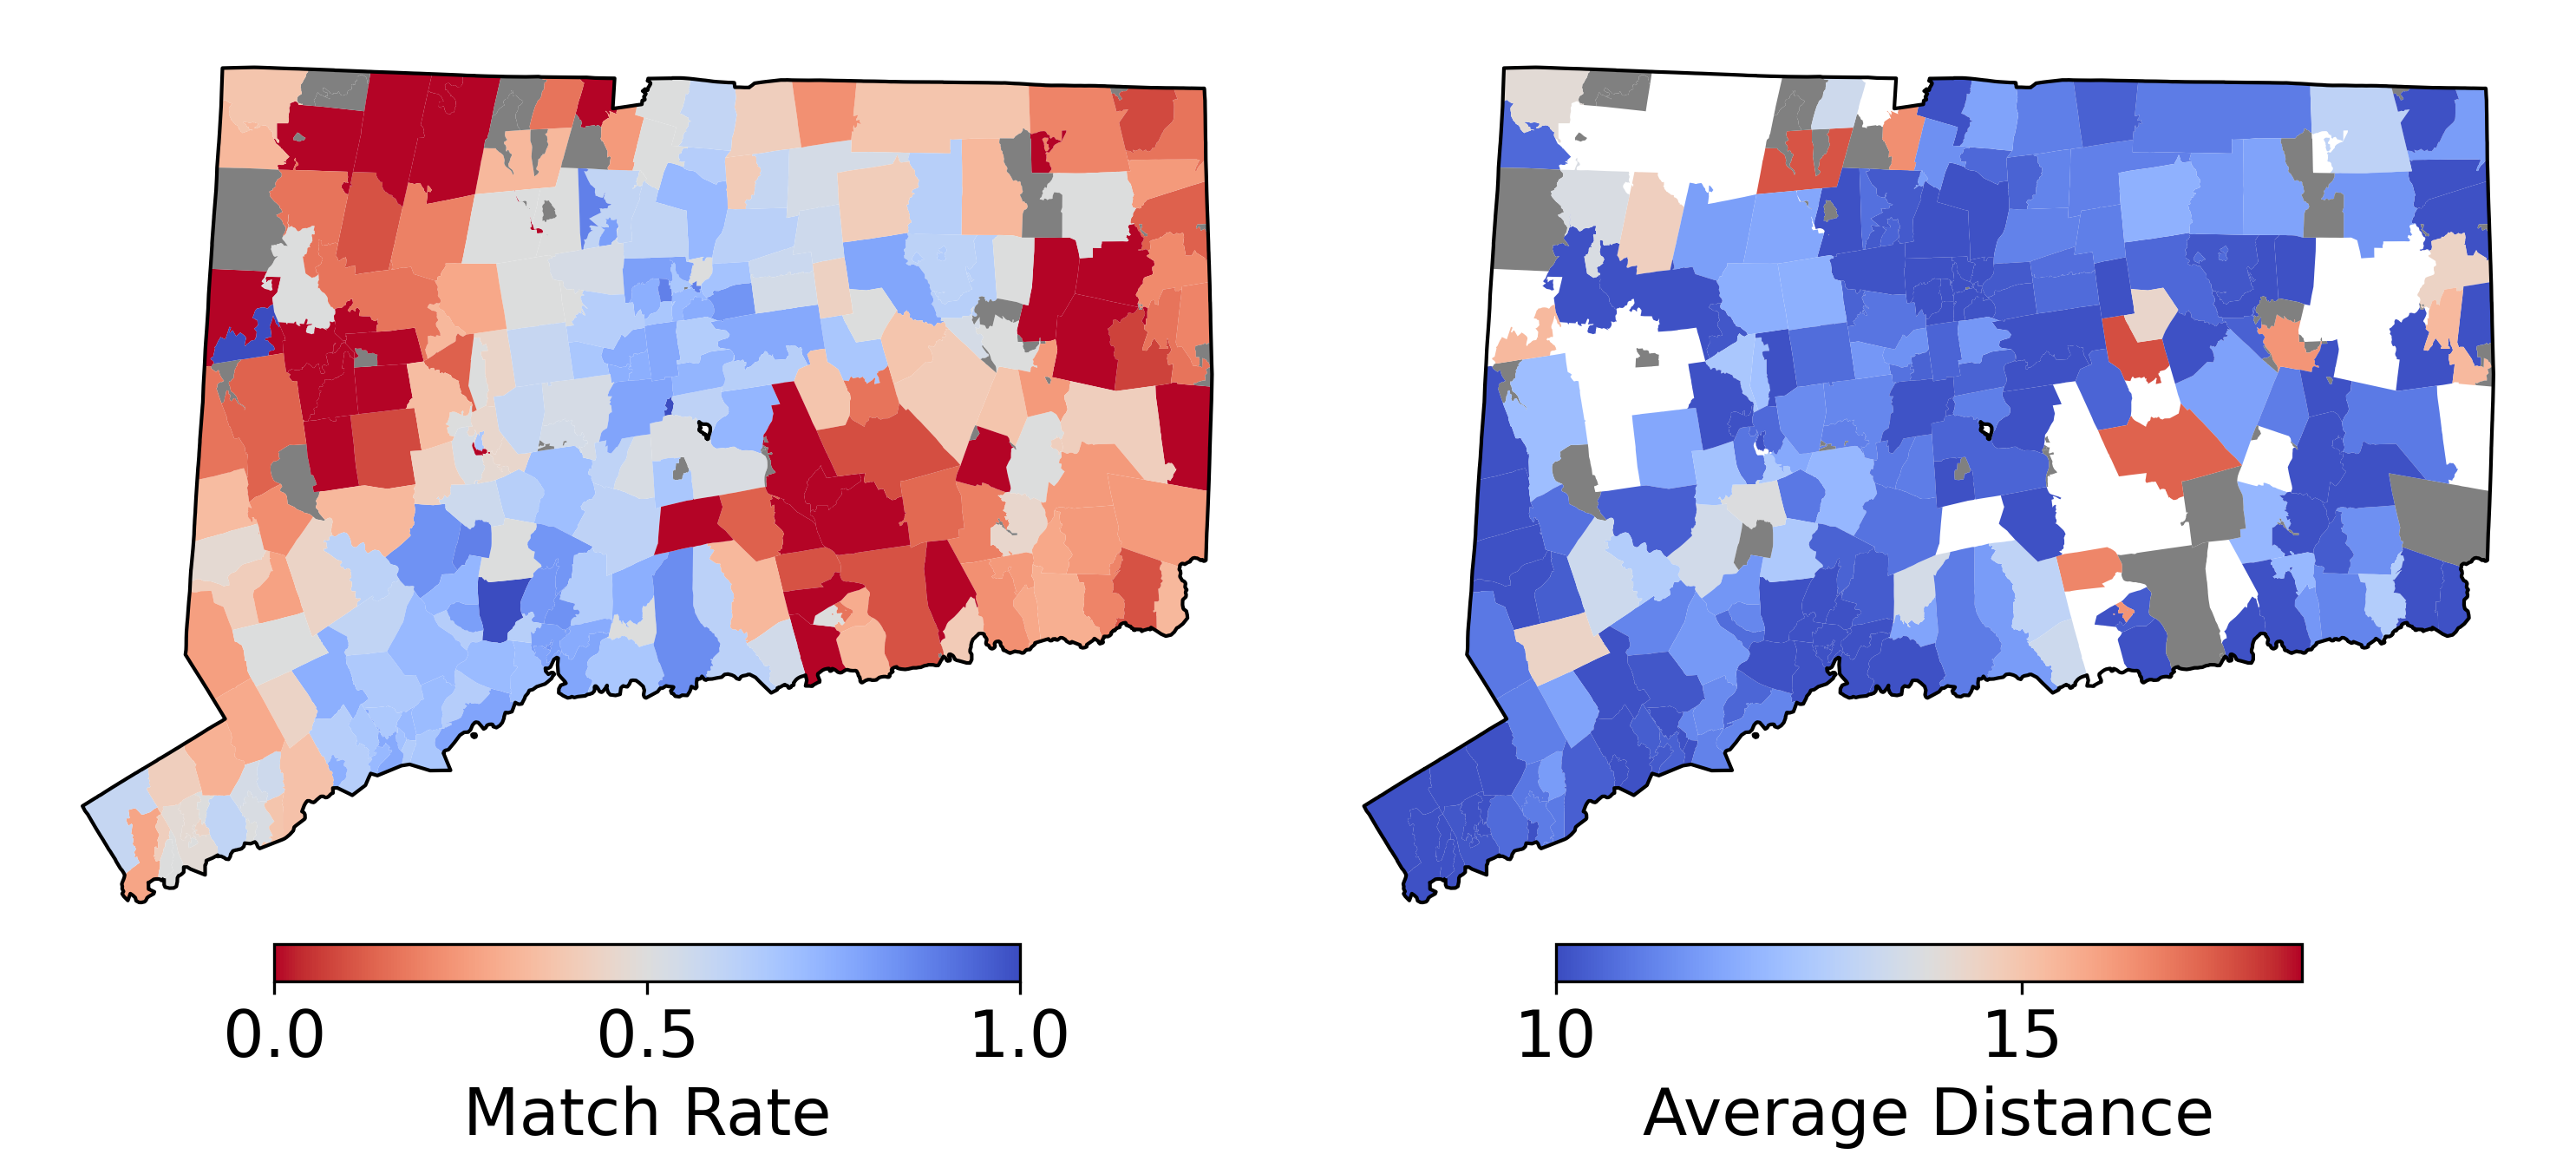

In [145]:
ct_zipcodes = gpd.read_file("../../data/ct.geojson")

# Generate random data for each ZIP code
ct_zipcodes["match_rate"] = [matches_by_zipcode[i] if i in matches_by_zipcode else -1 for i in ct_zipcodes["ZCTA5CE10"]]
ct_zipcodes["match_quality"] = [match_quality_by_zipcode[i] if i in match_quality_by_zipcode else -1 for i in ct_zipcodes["ZCTA5CE10"]]


cmap = mcolors.ListedColormap(["grey"] + plt.cm.coolwarm(np.linspace(0, 1, 256)).tolist())
norm = mcolors.BoundaryNorm(boundaries=[-1, 0, 1], ncolors=cmap.N, extend="both")

# Plotting the heatmap
fig, ax = plt.subplots(1,2,figsize=(10, 10))
cmap = plt.cm.coolwarm
cmap.set_under("grey")  # Values below the range (e.g., -1) will be grey
cmap.set_over("grey")   # Optionally, shade values above the range if needed

# Normalize the color range between 0 and 1
norm = mcolors.Normalize(vmin=0, vmax=1, clip=False)

ct_zipcodes.plot(
    column="match_rate",
    cmap=cmap.reversed(),
    norm=norm,
    legend=True,
    legend_kwds={
        'label': "Match Rate",
        'orientation': "horizontal",
        'shrink': 0.6,
        'pad': 0,
    },
    ax=ax[0]
)

norm = mcolors.Normalize(vmin=10, vmax=18, clip=False)


ct_zipcodes.plot(
    column="match_quality",
    cmap=cmap,
    norm=norm,
    legend=True,
    legend_kwds={
        'label': "Average Distance",
        'orientation': "horizontal",
        'shrink': 0.6,
        'pad': 0,
    },
    ax=ax[1]
)

ct_outline = ct_zipcodes.dissolve()
ct_outline.boundary.plot(ax=ax[0], color="black", linewidth=1)
ct_outline.boundary.plot(ax=ax[1], color="black", linewidth=1)


# Enhance the plot
ax[0].axis("off")
ax[1].axis("off")

# Show the plot
plt.tight_layout()
fig.savefig("../../results/figures/ct_match_rate.pdf",dpi=300, bbox_inches='tight')

In [200]:
batch_y_values = []
batch_y_confidences = []
baseline_params = {'utility_function': 'semi_synthetic', 'num_patients': 205, 'batch_size': 1, 'max_menu_size': 1000}
dataset = "semi_synthetic"
x_values = [1,2,3,4,5]
for i in range(len(x_values)):
    baseline_params['batch_size'] = x_values[i]

    results = get_results_matching_parameters(dataset,"",baseline_params)
    aggregate_data = aggregate_normalize_data(results,baseline="random")
    
    batch_y_values.append(aggregate_data['{}_utilities'.format("optimal_order")][0])
    batch_y_confidences.append(aggregate_data['{}_utilities'.format("optimal_order")][1]/len(results)**.5)

/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


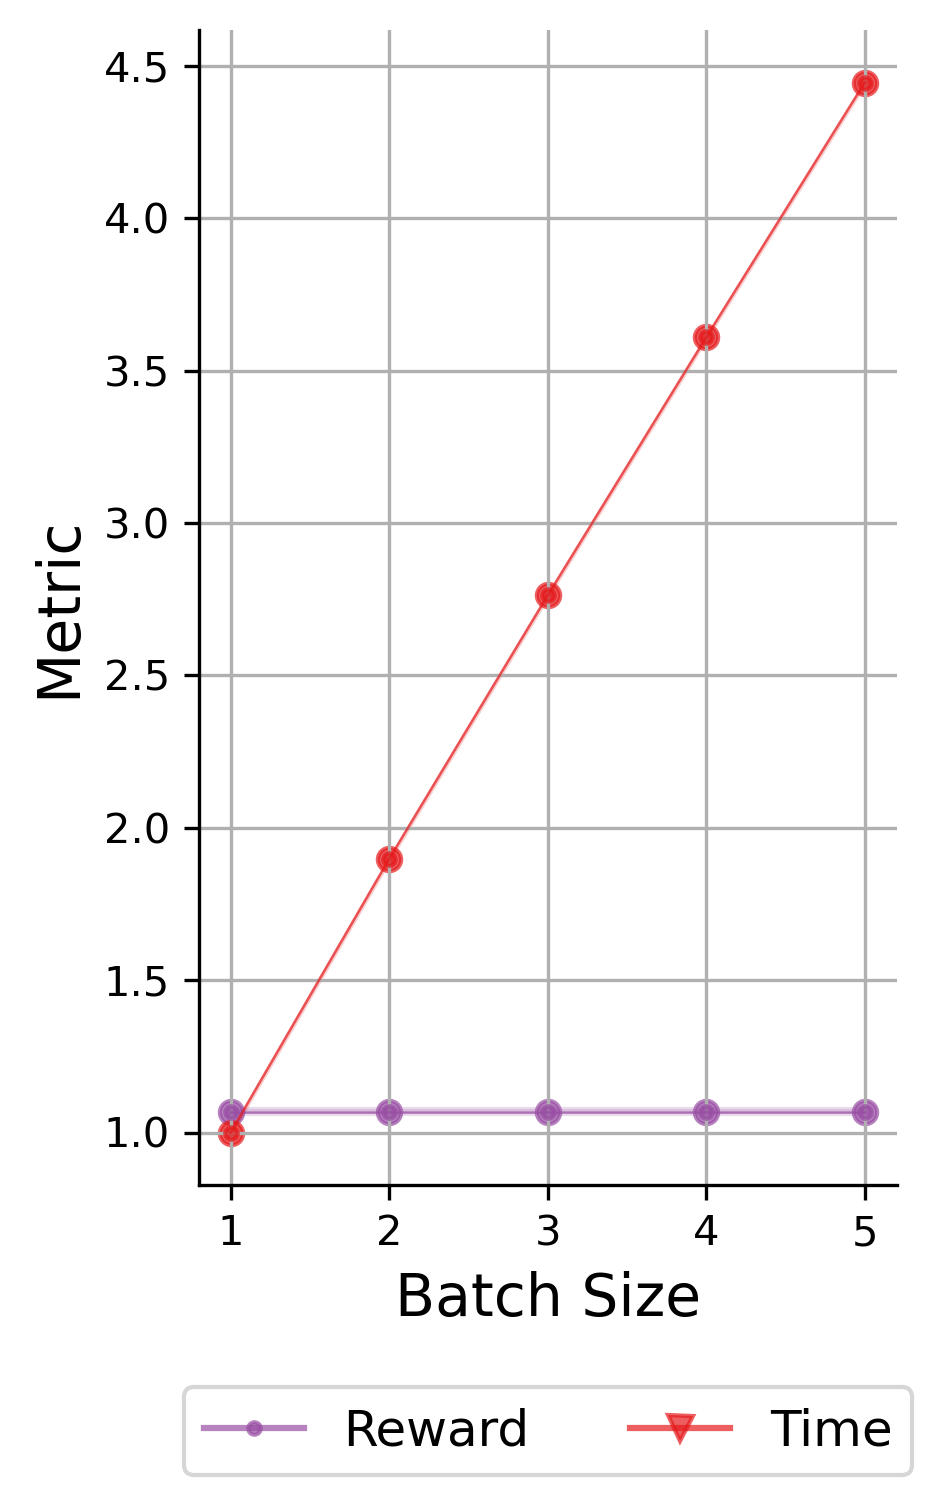

In [204]:
plot_dimensions = (1,1)
x_labels = [["Batch Size"]]
y_labels = [["Metric"]]
overall_format = {'figsize':(3,5),
    'style_size': style_size,
    'x_ticks': [[[x_values,x_values]]],
    'has_grid': True, 
}

fig,ax = create_axes(plot_dimensions,overall_format,x_labels=x_labels,y_labels=y_labels)

color = '#%02x%02x%02x%02x' % tuple(np.round(np.array(color_schemes['six_color'][-2])*256).astype(int).tolist())
line_format = {'color_palette': color, 'size': 125}
plot_line(ax[0][0],[x_values],[batch_y_values],batch_y_confidences,["Reward"],line_format)
plot_scatter(ax[0][0],[x_values],[batch_y_values],[None],line_format)

color = '#%02x%02x%02x%02x' % tuple(np.round(np.array(color_schemes['six_color'][-1])*256).astype(int).tolist())
line_format = {'color_palette': color, 'size': 125}
y_values = [x_values[i] * np.log(205/x_values[i])/np.log(np.log(205/x_values[i])) for i in range(len(x_values))]
y_values = [i/y_values[0] for i in y_values]
y_confidences = [0 for i in range(len(x_values))]
plot_line(ax[0][0],[x_values],[y_values],[y_confidences],["Time"],line_format)
plot_scatter(ax[0][0],[x_values],[y_values],[None],line_format)


legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'lower left', 'ncol': 5, 'bbox_to_anchor': (0.08,-0.1), 'show_point': True}
create_legend(fig,ax,plot_dimensions,legend_format)

fig.savefig("../../results/figures/batch_size.pdf",dpi=300, bbox_inches='tight')

In [206]:
menu_y_values = [[] for i in range(len(methods))]
menu_confidences = [[] for i in range(len(methods))]
baseline_params = {'utility_function': 'semi_synthetic', 'num_patients': 205, 'batch_size': 1}
dataset = "semi_synthetic"
x_values = [5,10,20,40]
for i in range(len(x_values)):
    baseline_params['max_menu_size'] = x_values[i]

    results = get_results_matching_parameters(dataset,"",baseline_params)
    aggregate_data = aggregate_normalize_data(results,baseline="random")
    for method in range(len(methods)):
        menu_y_values[method].append(aggregate_data['{}_utilities'.format(methods[method])][0])
        menu_confidences[method].append(aggregate_data['{}_utilities'.format(methods[method])][1]/len(results)**.5)

/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


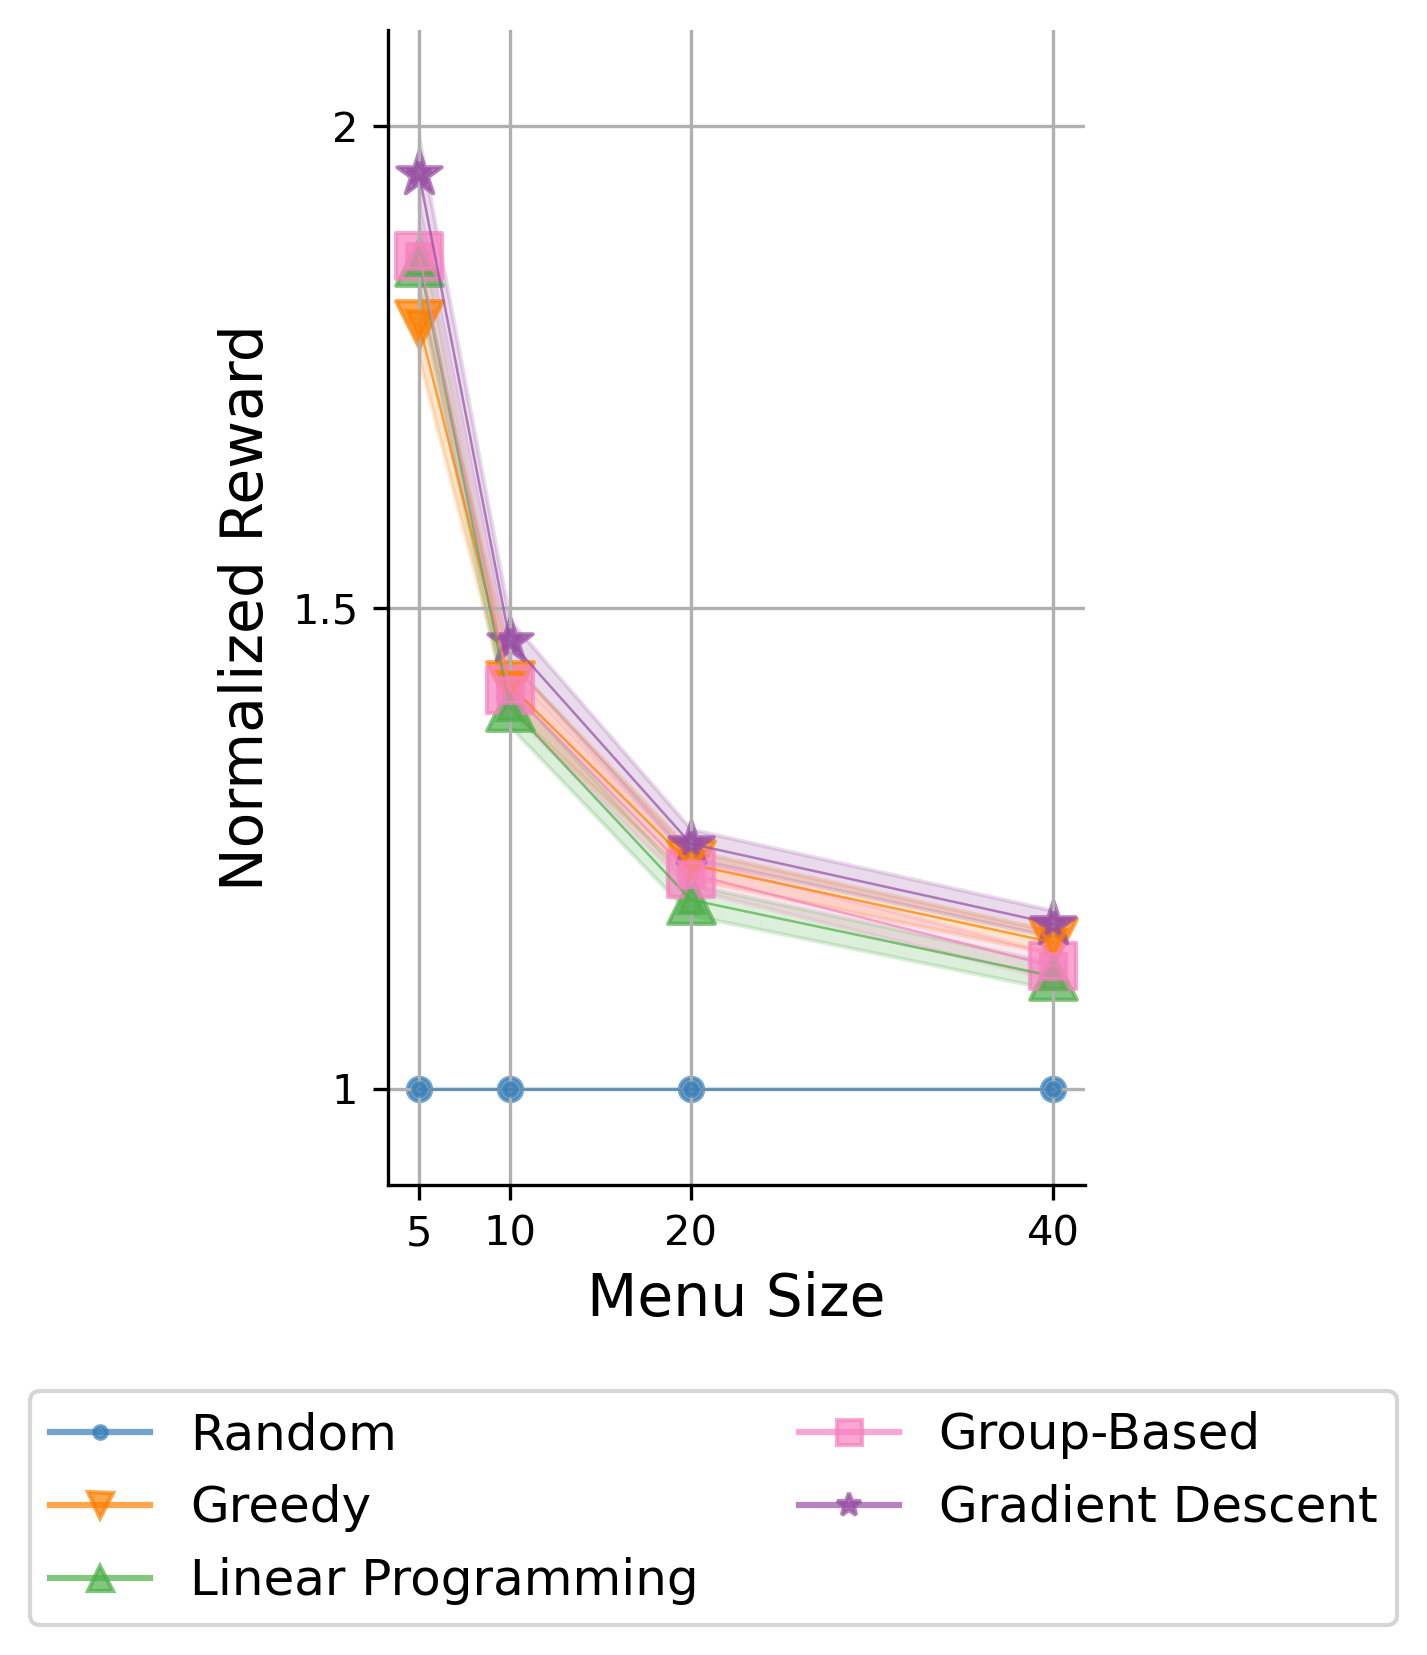

In [216]:
plot_dimensions = (1,1)
x_labels = [["Menu Size"]]
y_labels = [["Normalized Reward"]]
overall_format = {'figsize':(3,5),
    'style_size': style_size,
    'x_ticks': [[[x_values,x_values]]],
    'y_ticks': [[[[1,1.5,2],[1,1.5,2]]]],
    'y_lim': [[[0.9,2.1]]],
    'has_grid': True, 
}

fig,ax = create_axes(plot_dimensions,overall_format,x_labels=x_labels,y_labels=y_labels)

line_format = {'color_palette': 'six_color', 'size': 125}
plot_line(ax[0][0],[x_values for i in range(len(menu_y_values))],menu_y_values,menu_confidences,method_labels,line_format)
plot_scatter(ax[0][0],[x_values for i in range(len(menu_y_values))],menu_y_values,[None for i in range(len(method_labels))],line_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'lower left', 'ncol': 2, 'bbox_to_anchor': (-0.3,-0.2), 'show_point': True}
create_legend(fig,ax,plot_dimensions,legend_format)

fig.savefig("../../results/figures/max_menu_size.pdf",dpi=300, bbox_inches='tight')